In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

import os
import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

In [2]:
####################################
# INPUT: read heatwave algorithm output dataset
####################################

def enter_sas_token():
    """Obtain sas token from Azure, and enter to the input box that opens."""
    sas_token = getpass.getpass()
    return sas_token
    
def import_dataset(url_prefix:str, filename:str, sas_token:str) -> np.array:

    if url_prefix[-1] != '/':
        url_prefix += '/' 
    
    sas_url = url_prefix + filename + "?" + sas_token    

    if os.path.isfile(filename):
        ds = xr.open_mfdataset(filename, concat_dim="time", combine="nested")
        
    else:
        blob_client = BlobClient.from_blob_url(sas_url)
        with open(filename, "wb") as my_blob:
            download_stream = blob_client.download_blob()
            my_blob.write(download_stream.readall())
  
        ds = xr.open_mfdataset(filename, concat_dim="time", combine="nested")

    return ds

In [3]:
url_prefix = 'https://nasanex30analysis.blob.core.windows.net/cmip6/'
sas_token = enter_sas_token() # of the whole "cmip6" folder in Azure.

 ····································································································································


In [4]:
# import heatwave flag data:
filename = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds_heat = import_dataset(url_prefix+"extremes_max/", filename, sas_token)

print(ds_heat.attrs['Number of continuous days to be considered extreme'], "days")
print(ds_heat.attrs['threshold'], "K above")

4 days
5 K above


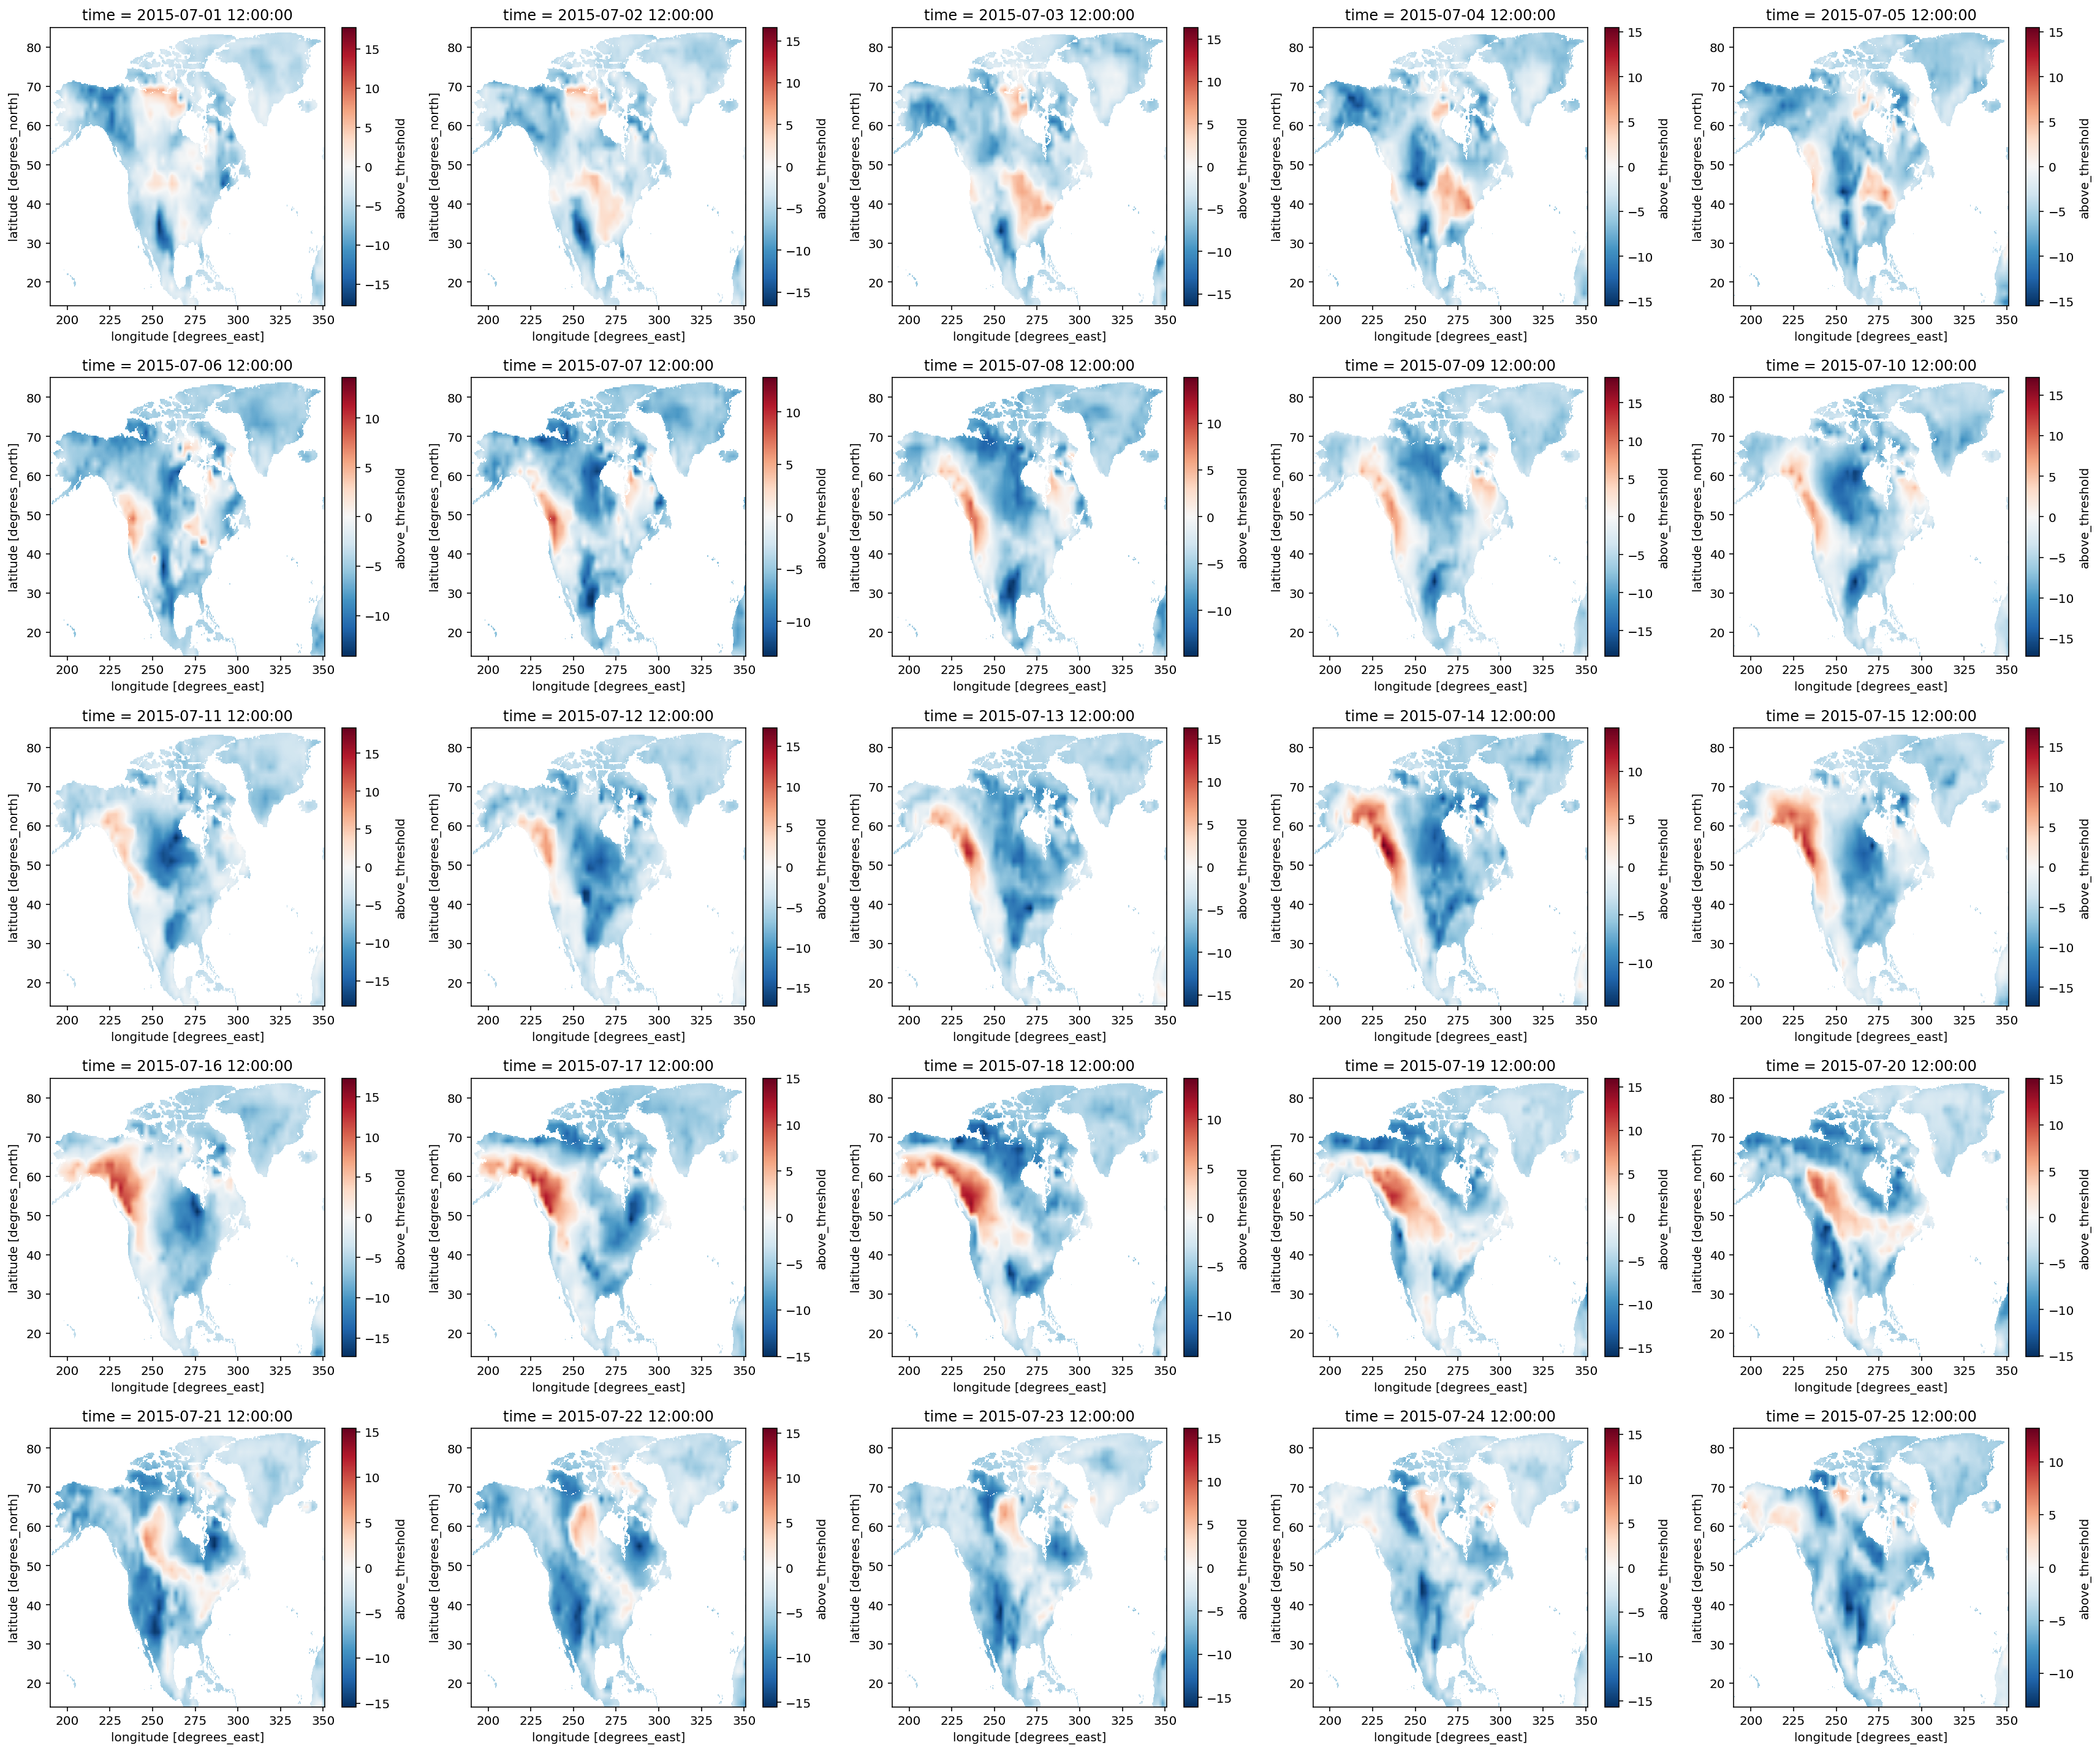

In [31]:

fig, axs = plt.subplots(5,5, figsize=(24,20))

for i in range(25):
    ax = axs.ravel()[i]
    ds_heat.sel(time=f'2015-07-{str(i+1).zfill(2)}')['above_threshold'].plot(ax=ax)

plt.tight_layout()

In [ ]:
# # import row temp data:
# filename = f"10_year_max_temp_CMIP6__Region_1__2020_to_2029.nc"
# ds_temp = import_dataset(url_prefix+"10_year_temp/", filename, sas_token)

# # import tem_avg data:
# filename = f"Avg_temp_max_CMIP6__30_yrs__1950_to_1979.nc"
# ds_avg = import_dataset(url_prefix+"averages/", filename, sas_token)

# # import heatwave flag data:
# filename = f"10_year_Heatwaves_Data_CMIP6_ssp245__Region_1__2020_to_2029.nc.nc"
# ds_heat = import_dataset(url_prefix+"heatwaves/", filename, sas_token)

In [7]:
SAS_TOKEN = getpass.getpass() # of the whole "cmip6" folder in Azure.
URL_PREFIX = 'https://nasanex30analysis.blob.core.windows.net/cmip6'

 ········································································································································


In [10]:
import tempfile

class AzureSource():

    def __init__(self, model:str, year:int):
        fn = f"Ext_max_t__Rgn_1__{year}__Abv_Avg_5_K_for_3_days__CMIP6_{model}_Avg_yrs_1950_79.nc"
        self.filename = fn
        abspath = f"extremes_max/{model}/Region_1/Avg_yrs_1950_79/Abv_Avg_5_K_for_3_days/{fn}" 
        self.abspath = abspath
            
    def download(self):
        
        if not os.path.isfile(self.filename):
            
            sas_url = f"{URL_PREFIX}/{self.abspath}?{SAS_TOKEN}"
            blob_client = BlobClient.from_blob_url(sas_url)

            with tempfile.TemporaryFile() as f:
                fp = f"{f.name}.tmp"
                with open(fp, "wb") as my_blob:
                    download_stream = blob_client.download_blob()
                    my_blob.write(download_stream.readall())

                    os.rename(fp, self.filename)
                    while os.path.getsize(self.filename)/10**6 < 10: # MB
                        time.sleep(2) 

# download single file for image generation
model = "GISS_E2_1_G_ssp585"
year = 2020

at = AzureSource(model, year)
at.download()